In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

sns.set_style('darkgrid')

In [2]:
user_items = pd.read_parquet(r"C:\Users\roylo\OneDrive\Documentos\Data Science\Proyectos Individuales\Machine Learning Operations\Datasets\user_items.parquet")

user_items.head()

,user_id,items_count,item_id,item_name
0,76561197970982479,277,"[10, 20, 30, 40, 50, 60, 70, 130, 300, 240, 38...","[Counter-Strike, Team Fortress Classic, Day of..."
1,js41637,888,"[10, 80, 100, 300, 30, 40, 60, 240, 280, 360, ...","[Counter-Strike, Counter-Strike: Condition Zer..."
2,evcentric,137,"[1200, 1230, 1280, 1520, 220, 320, 340, 360, 3...","[Red Orchestra: Ostfront 41-45, Mare Nostrum, ..."
3,Riot-Punch,328,"[10, 20, 30, 40, 50, 60, 70, 130, 80, 100, 300...","[Counter-Strike, Team Fortress Classic, Day of..."
4,doctr,541,"[300, 20, 50, 70, 130, 10, 30, 40, 60, 80, 100...","[Day of Defeat: Source, Team Fortress Classic,..."


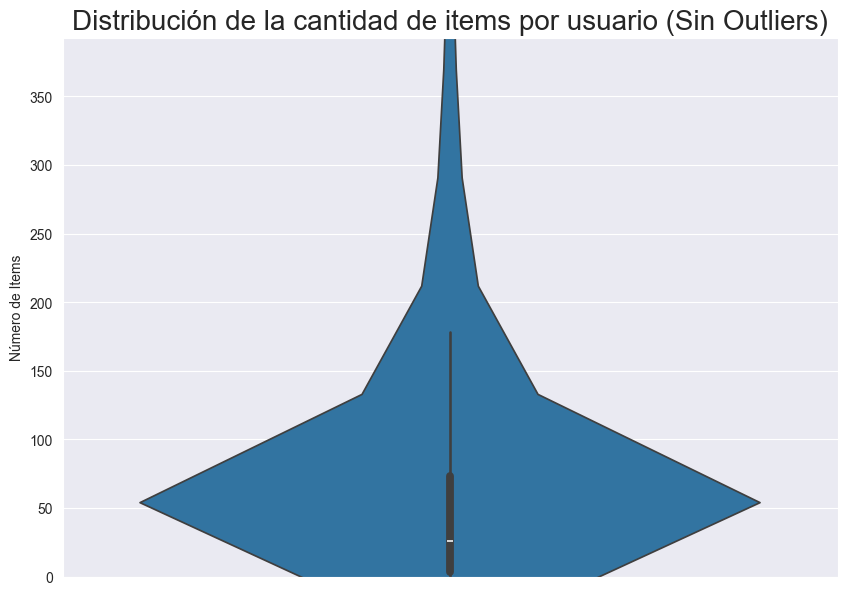

In [3]:
media = np.median(user_items['items_count'].sort_values())

plt.figure(figsize=(10,7))

sns.violinplot(user_items['items_count'])

plt.title("Distribución de la cantidad de items por usuario (Sin Outliers)",fontsize=20)
plt.ylabel("Número de Items")
plt.ylim(0, media+(3*np.std(user_items['items_count'])))
plt.show()

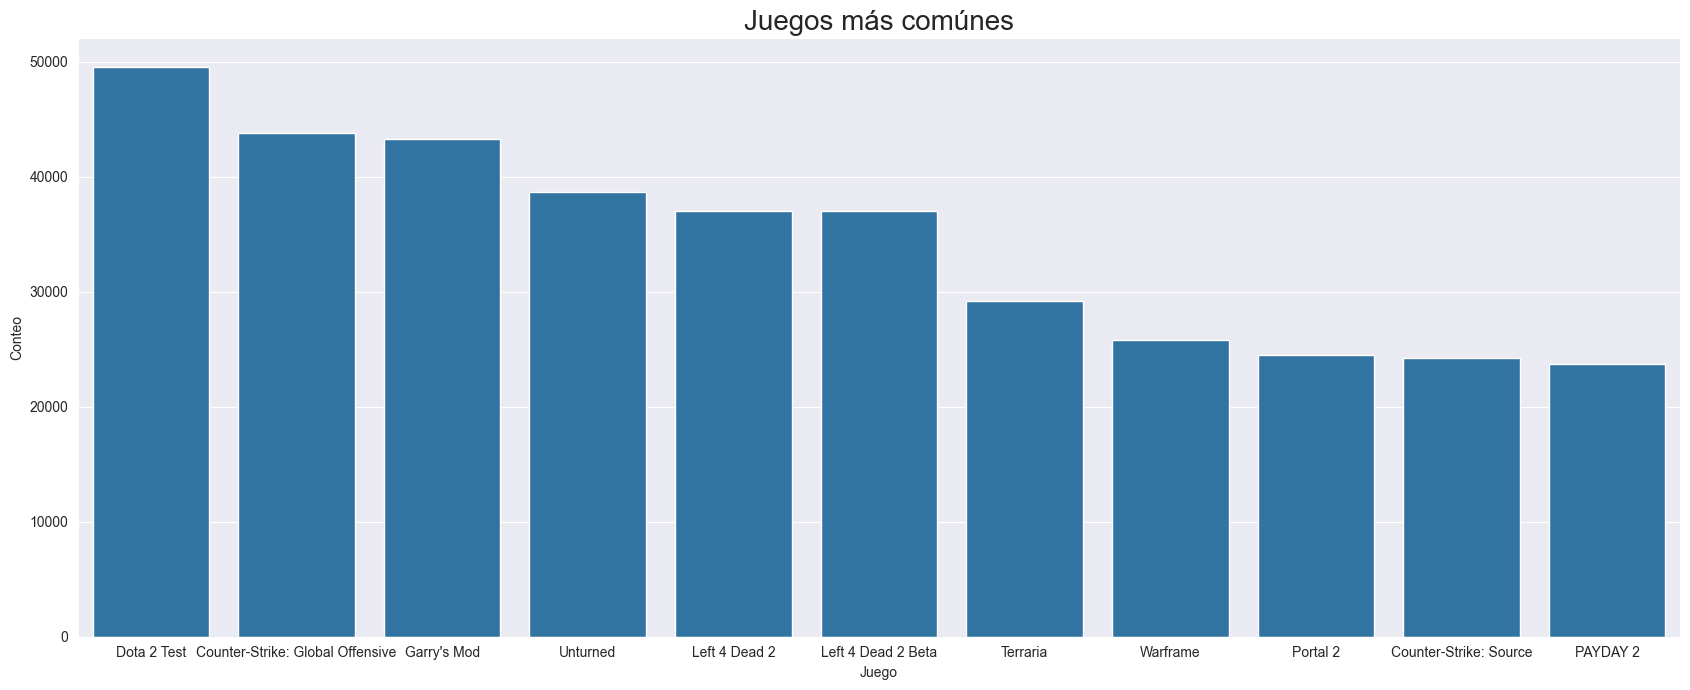

In [4]:
item_names = user_items['item_name'].explode().reset_index(drop=True)

item_names_count = item_names.value_counts().index[:11]

plt.figure(figsize=(17,7))

sns.countplot(x=item_names,order=item_names_count)

plt.title("Juegos más comúnes",fontsize=20)
plt.ylabel("Conteo")
plt.xlabel("Juego")
plt.tight_layout()
plt.show()

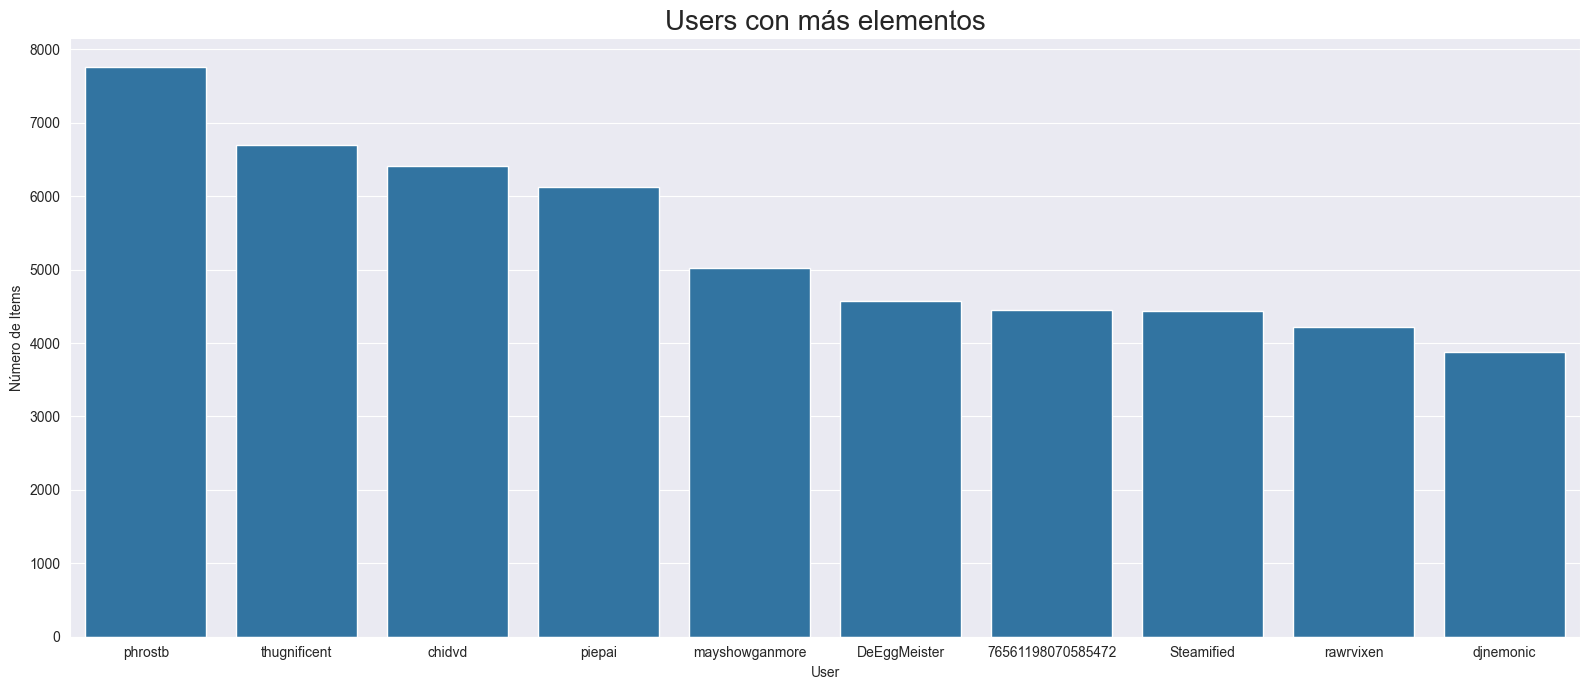

In [12]:
users = user_items[['user_id','items_count']].sort_values(by='items_count',ascending=False)[:10]

plt.figure(figsize=(16,7))

sns.barplot(data=users, x='user_id',y='items_count',)

plt.title("Users con más elementos",fontsize=20)
plt.ylabel("Número de Items")
plt.xlabel("User")
plt.tight_layout()
plt.show()